<a href="https://colab.research.google.com/github/ttourneux/Final-Project/blob/main/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## questions: 
- do we need to use nn.Sequential? what are the advantages of using it? 
- are we supposed to assign self.decoder = nn.sequential(... all the layers)

- am I implementing the VAE loss correctly?

- what is the shape of z? 

### Author Information
Name: \<FILL HERE\>

B-Number: \<FILL HERE\>

Email: \<FILL HERE\>

## General Instructions 
### Due December 5th, 11:59 PM.

In the following assignment, you will be using variational autoencoders (VAEs) and generative adversarial networks (GANs) to generate new handwritten digits similar to the MNIST dataset.   


Functions and cells that need to be implemented are marked with a bold **implement** keyword or clearly marked in the experiments section. 

The experiments section for each classifier also need to be implemented. You should follow the instructions above the cell. You may also add additional cells. 

# Import Statements

In [1]:
import math
import random
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from tqdm import tqdm

%matplotlib inline


# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Dataset
Generative models are notoriously finicky with hyperparameters, and also require many training epochs. 

We will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). 

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

In [2]:
'''# Mount the drive
from google.colab import drive
drive.mount('/content/drive')'''

"# Mount the drive\nfrom google.colab import drive\ndrive.mount('/content/drive')"

*Run* the following the following cell to download the MNIST data set.

In [3]:
batch_size = 128

print('download MNIST if not exist')

mnist_train = dset.MNIST('./MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)


imgs = loader_train.__iter__().next()[0].view(batch_size, 784)

download MNIST if not exist


*Run* this cell to define the helper function to generate grids of images. 

In [4]:
def show_images(images):
    images = torch.reshape(
        images, [images.shape[0], -1]
    )  # images reshape to (batch_size, D)
    sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
    sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(img.reshape([sqrtimg, sqrtimg]))
    return

*Run* the following cell to show an example of a grid of MNIST images.

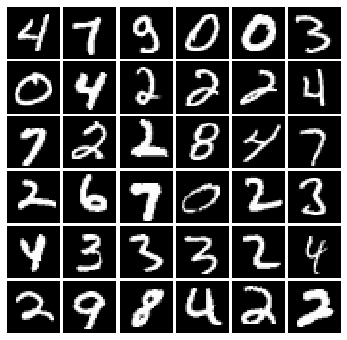

In [5]:
show_images(imgs[:36])

# (Part 1) Variational Autoencoder - 40 pts



## VAE Encoder

Now lets start building our fully-connected VAE network.
Start with the encoder,
which will take our images as input and pass them through a three Linear+ReLU layers.
You will use the output of these layers to predict both the posterior mu and posterior log-variance using two separate linear layers (both shape (N,Z)). 


Use nn.Sequential to define the encoder, and separate Linear layers for the mu and logvar layers. In all of these layers, H will be a hidden dimension you set and will be the same across all encoder and decoder layers. Architecture for the encoder is described below:

 * `Flatten` (Hint: nn.Flatten)
 * Fully connected layer with input size 784 (`input_size`) and output size H
 * `ReLU`
 * Fully connected layer with input_size H and output size H
 * `ReLU`
 * Fully connected layer with input_size H and output size H
 * `ReLU`

Complete the `Encoder` class by completing the `self.__init__` and `self.forward` methods.  

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super().__init__()

        # ==== BEGIN SOLUTION CODE ====   
        self.input_size = input_size 
        self.hidden_dim = hidden_dim     

        self.flatten = nn.Flatten()

        self.ReLU = nn.ReLU()
        self.fc1 = nn.Linear(784,self.hidden_dim) 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)

        self.encoder = nn.Sequential(
            self.flatten,
            self.fc1,self.ReLU,
            self.fc2, self.ReLU,
            self.fc3, self.ReLU
        )

        

        # ==== END SOLUTION CODE ====

    def forward(self, x):
        '''
        Use the self._encoder to encode the image to the hidden dimension
        
        Inputs:
        - x: Tensor of shape (N, 1, H, W ) where H * W = input_size

        Returns:
        - h: Tensor of shape (N , hidden_dim)
        '''
        #h = None
        # ==== BEGIN SOLUTION CODE ====
        '''x = self.flatten(x)
        x = self.fc1(x)
        x = self.ReLU(x) 
        x = self.fc2(x) 
        x = self.ReLU(x) 
        x = self.fc3(x) 
        h = x '''
        h = self.encoder(x)

        # ==== END SOLUTION CODE ====
        return h

*Implement* a sanity check in the following cell to run a `(32, 1, 28, 28)` random tensor through an encoder initialized with size `786` and `96` dim hidden dimension. The output should be `(32, 96)`. 

In [7]:
# ==== BEGIN SOLUTION CODE ====
encoder = Encoder(786,96)
rtensor = torch.rand((32,1,28,28))

ans = encoder.forward(rtensor)
ans.shape

# ==== END SOLUTION CODE ====

torch.Size([32, 96])

## VAE Decoder

**Implement** the Decoder, which will take the latent space representation and generate a reconstructed image. The architecture is as follows: 

 * Fully connected layer with input size as the latent size (Z) and output size hidden dim (H)
 * `ReLU`
 * Fully connected layer with input_size H and output size H
 * `ReLU`
 * Fully connected layer with input_size H and output size H
 * `ReLU`
 * Fully connected layer with input_size H and output size (`output_size` = 784)
 * `Sigmoid`
 * `Unflatten` (nn.Unflatten: shape=(1,28,28))

Use `nn.Sequential` to define the architecture in `self._decoder`. 

Complete the `Decoder` class by completing the `self.__init__` and `self.forward` methods.  


In [8]:
class Decoder(nn.Module):
    def __init__(self, latent_size, hidden_dim, height=28, width=28):
        super().__init__()
        self._decoder = None
        self.latent_size = latent_size
        self.hidden_dim = hidden_dim
        self.height = height
        self.width = width
        self.output_size = height * width

        # ==== BEGIN SOLUTION CODE ====
        self.ReLU = nn.ReLU()
        
        self.fc1 = nn.Linear(self.latent_size,self.hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim) 
        self.fc3 = nn.Linear(hidden_dim, hidden_dim) 
        self.fc4 = nn.Linear(hidden_dim, self.output_size)

        self.sigmoid = nn.Sigmoid()

        self.unflatten = nn.Unflatten(1, (1,self.width,self.height))

        self.decoder = nn.Sequential(
            self.fc1,self.ReLU,

            self.fc2,self.ReLU,

            self.fc3,self.ReLU,

            self.fc4,self.sigmoid,

            self.unflatten,


        )



        # ==== END SOLUTION CODE ====


    def forward(self, z):
        """
        Use the self._decoder to reconstruct the image
        
        Inputs:
        - Z: Tensor of shape (N, Z) giving the latent vector

        Returns:
        - x_reconstructed: Reconstruced input data of shape (N,1,H,W)
          whete, H is self.height, and W is self.width
        """
        x_reconstructed = None

        # ==== BEGIN SOLUTION CODE ====
        '''
        x = self.fc1(z)
        x = self.ReLU(x) 


        x = self.fc2(x) 
        x = self.ReLU(x)

        x = self.fc3(x) 
        x = self.ReLU(x)

        x = self.fc4(x) 
        x = self.sigmoid(x) 

        x_reconstructed = self.unflatten(x)'''


        x_reconstructed = self.decoder(z)


        # ==== END SOLUTION CODE ====
        return x_reconstructed    


*Implement* a sanity check in the following cell to run a `(16, 32)` random tensor through a decoder initialized with a `32` and `96` dim latent space and hidden dimension respectively. The output should be `(16, 1, 28, 28)`

In [9]:
# ==== BEGIN SOLUTION CODE ====
        

decoder = Decoder(32,96)
rtensor = torch.rand((16,32))

ans = decoder.forward(rtensor)
ans.shape
# ==== END SOLUTION CODE ====

torch.Size([16, 1, 28, 28])

## Reparameterization Trick

Apply a reparametrization trick in order to estimate the posterior $z$ during our forward pass, given the $\mu$ and $log(\sigma^2)$ estimated by the encoder.

In order to be able to backprop through the probabilistic latent space, we sample initial random data $\epsilon$ from a fixed distrubtion, and compute $z$ as a function of ($\epsilon$, $\log(\sigma^2)$, $\mu$). Specifically:

$z = \mu + \sigma\epsilon$

We can easily find the partial derivatives w.r.t $\mu$ and $\sigma^2$ and backpropagate through $z$. If $\epsilon = \mathcal{N} (0,1)$, then it's easy to verify that the result of our forward pass calculation will be a distribution centered at $\mu$ with variance $\sigma^2$.

Not that the encoder outputs $\log(\sigma^2))$. So you will need to transform the output first before applying the reparameterization trick. 


**Implement** the reparametrize function.

In [10]:
def reparameterize(mu, logvar):
    """
    Differentiably sample random Gaussian data with specified mean and variance
    using the reparameterization trick.

    We want to sample a random number z from a Gaussian distribution with
    mean mu and standard deviation sigma, such that we can backpropagate from the
    z back to mu and sigma. We can achieve this by first sampling a random value
    epsilon from a standard Gaussian distribution with zero mean and unit variance,
    then setting z = sigma * epsilon + mu.

    For more stable training when integrating this function into a neural network,
    it helps to pass this function the log of the variance of the distribution from
    which to sample, rather than specifying the standard deviation directly.

    Inputs:
    - mu: Tensor of shape (N, Z) giving means
    - logvar: Tensor of shape (N, Z) giving log-variances

    Returns:
    - z: Estimated latent vectors, where z[i, j] is a random value sampled from a
      Gaussian with mean mu[i, j] and log-variance logvar[i, j].
    """

    # ==== BEGIN SOLUTION CODE ====
    N,Z = mu.shape
    epsilon = torch.normal(torch.zeros((N,Z)),torch.ones(N,Z)).to(device)
    sigma = torch.exp(logvar).to(device)

    mu = mu.to(device)

    z = sigma*epsilon + mu
    assert(z.shape == (N,Z))
    # ==== END SOLUTION CODE ====
    
    return z

## VAE Model



**Implement** the following cell and complete the implementation of the VAE class. You will need to complete the `self.__init__`, and `self.forward` methods. 

To complete the `self.__init__` method: 
- Define self.encoder which should be a network that
inputs a batch of input images of shape (N, 1, H, W) into a batch of hidden features of shape (N, H_d). Use the `Encoder` class you defined before. 

- Set up self.mu_layer and self.logvar_layer to be a pair of linear layers that map the hidden features into estimates of the mean and log-variance of the posterior over the latent vectors; the mean and log-variance estimates will both be tensors of shape (N, Z). 
Note that we are calling this the 'logvar' layer because we'll use the log-variance (instead of variance or standard deviation) to stabilize training. This will specifically matter more when you compute reparametrization and the loss function. 

- Define self.decoder which should be a network that inputs a batch of latent vectors of shape (N, Z) and outputs a tensor of estimated images of shape (N, 1, H, W). Use the `Decoder` class you defined before. 

To complete the `self.forward` method:

- Get the hidden dimension vector by calling passing the input through the encoder

- Use `self.mu_layer` and `self.logvag_layer` to obtain the posterior mu and logvar

- Use the `reparameterize` function to compute the latent vector z

- Use the decoder to reconstruct the input 

- Return the reconstructed input, the posterior mean, and the posterior logvar. 

In [11]:
class VAE(nn.Module):
    def __init__(self, height, width, hidden_dim=96, latent_size=16):
        super(VAE, self).__init__()
        self.height = height
        self.width = width
        self.input_size = height * width  # H*W
        self.latent_size = latent_size  # Z
        self.hidden_dim = hidden_dim  
        self.encoder = None
        self.mu_layer = None
        self.logvar_layer = None
        self.decoder = None

        # ==== BEGIN SOLUTION CODE ====

        self.encoder = Encoder(height*width, hidden_dim=hidden_dim)

        self.decoder = Decoder(latent_size = self.latent_size,hidden_dim=hidden_dim)

        self.mu_layer =nn.Linear(hidden_dim,latent_size)

        self.logvar_layer = nn.Linear(hidden_dim,latent_size)
        # ==== END SOLUTION CODE ====
        

    def forward(self, x):
        """
        Performs forward pass through VAE model by passing image through
        encoder, reparametrize trick, and decoder models

        Inputs:
        - x: Batch of input images of shape (N, 1, H, W)

        Returns:
        - x_hat: Reconstruced input data of shape (N,1,H,W)
        - mu: Matrix representing estimated posterior mu (N, Z), with Z latent
          space dimension
        - logvar: Matrix representing estimataed variance in log-space (N, Z),
          with Z latent space dimension
        """
        x_hat = None
        mu = None
        logvar = None
        # ==== BEGIN SOLUTION CODE ====
        hd_vector = self.encoder(x)
        mu = self.mu_layer(hd_vector)
        logvar = self.logvar_layer(hd_vector)

        z = reparameterize(mu, logvar)
        assert(z.shape == (128,self.latent_size))
        

        x_hat = self.decoder(z)

        N,one,H,W = x.shape
        assert(x_hat.shape == (N,1,H,W))
        assert(mu.shape == (N,self.latent_size))
        assert(logvar.shape == (N,self.latent_size) )
        # ==== END SOLUTION CODE ====
        return x_hat, mu, logvar

## VAE Loss

Before we're able to train our final model, we'll need to define our loss function. As seen below, the loss function for VAEs contains two terms: A reconstruction loss term (left) and KL divergence term (right). 

$$-E_{Z~q_{\phi}(z|x)}[log p_{\theta}(x|z)] + D_{KL}(q_{\phi}(z|x), p(z)))$$

Note that this is the negative of the variational lowerbound shown in lecture--this ensures that when we are minimizing this loss term, we're maximizing the variational lowerbound. The reconstruction loss term can be computed by simply using the binary cross entropy loss between the original input pixels and the output pixels of our decoder (Hint: `nn.functional.binary_cross_entropy` but choose the correct reduction). The KL divergence term works to force the latent space distribution to be close to a prior distribution (we're using a standard normal gaussian as our prior).

To help you out, we've derived an unvectorized form of the KL divergence term for you.
Suppose that $q_\phi(z|x)$ is a $Z$-dimensional diagonal Gaussian with mean $\mu_{z|x}$ of shape $(Z,)$ and standard deviation $\sigma_{z|x}$ of shape $(Z,)$, and that $p(z)$ is a $Z$-dimensional Gaussian with zero mean and unit variance. Then we can write the KL divergence term as:

$$D_{KL}(q_{\phi}(z|x), p(z))) = -\frac{1}{2} \sum_{j=1}^{Z} (1 + log(\sigma_{z|x}^2)_{j} - (\mu_{z|x})^2_{j} - (\sigma_{z|x})^2_{j})$$

**Implement** this loss that also operates on minibatches.
You should average the loss across samples in the minibatch.



In [26]:
def VAE_Loss(x, x_reconstructed, mu, logvar):
  loss = None
  # ==== BEGIN SOLUTION CODE ====

  reconstruction_loss = nn.functional.binary_cross_entropy(x_reconstructed,x)

  N,Z = mu.shape
  losses = []
  '''for sample in range(N): 
    total = 0 
    for j in range(Z): 
      total+= ( (1+logvar[sample,j]) - (mu[sample,j])**2 - torch.exp(logvar)[sample,j]**2 )## we might be able to do this in a vectorized fashion 
    total = -total/2#float(total/2)
    #print('total',total)

    losses.append(total)
  #print('losses',losses)
  loss = (sum(losses)/len(losses) ) + reconstruction_loss'''
  #print('logvar',logvar)
  #print('mu',mu)

  d_KL = torch.ones((N,Z)).to(device) + logvar - mu**2 - torch.exp(logvar)**2
  d_KL_loss = -.5*sum(d_KL.flatten())/len(d_KL.flatten())
  
  ##print('d_KL_loss',d_KL_loss)
  #print('reconstruction_loss', reconstruction_loss)
  # ==== END SOLUTION CODE ====
  return d_KL_loss + reconstruction_loss

In [13]:
'''def VAE_Loss(x, x_reconstructed, mu, logvar):
  loss = None
  # ==== BEGIN SOLUTION CODE ====

  reconstruction_loss = nn.functional.binary_cross_entropy(x,x_reconstructed)

  N,Z = mu.shape
  losses = []
  for sample in range(N): 
    total = 0 
    for j in range(Z): 
      total+= ( (1+logvar[sample,j]) - (mu[sample,j])**2 - torch.exp(logvar)[sample,j]**2 )## we might be able to do this in a vectorized fashion 
    total = -total/2#float(total/2)
    #print('total',total)

    losses.append(total)
  #print('losses',losses)
  loss = (sum(losses)/len(losses) ) + reconstruction_loss
  # ==== END SOLUTION CODE ====
  return loss'''

## VAE Training

In the following cell, define a VAE and train on the training set. 

The VAE training algorithm is as follows:

1. Instantiate a `VAE` 
    - Suggested: hidden_dim = 96, latent_dim = 16
2. Define a vae optimizer
    - Suggested: ADAM with lr .001
3. For each batch of data;
    - Pass the input through the VAE to get the reconstructed input, the mean and log-var approximate of the posterior
    - Calculate the loss using the `VAE_Loss` 
    - Zero the gradients, propagate the loss backwards, and update the  weights using the optimizer

4. Repeat 3, `num_epoch` times
    - Suggested: 10 times. 

*Following the suggested hyper-parameters, training takes approximately 2 minutes.* 

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [15]:
'''mnist_train, mnist_val = torch.utils.data.random_split(training_mnist, lengths =[int(len(training_mnist)*.80),int(len(training_mnist)*.2)])

train_loader = DataLoader(dataset = mnist_train, batch_size = BATCH_SIZE)
val_loader = DataLoader(dataset = mnist_val, batch_size = BATCH_SIZE)'''

'mnist_train, mnist_val = torch.utils.data.random_split(training_mnist, lengths =[int(len(training_mnist)*.80),int(len(training_mnist)*.2)])\n\ntrain_loader = DataLoader(dataset = mnist_train, batch_size = BATCH_SIZE)\nval_loader = DataLoader(dataset = mnist_val, batch_size = BATCH_SIZE)'

In [16]:
#kl_div_loss = torch.nn.functional.kl_div(input, target, )

In [17]:
logvar.shape

NameError: ignored

In [28]:
# ==== BEGIN SOLUTION CODE ====
model = VAE(28,28,hidden_dim=96,latent_size =16)
model.to(device)
#BATCH_SIZE = 16 ## this is already set in the dataLoader
EPOCHS = 10
optimizer = torch.optim.Adam(model.parameters(),lr = .001)

loss_stats= []

for epoch in tqdm(range(1,EPOCHS+1),disable = True):
  train_epoch_loss = 0 
  model.train()
  for x_train_batch, y_train_batch in tqdm(loader_train, disable = 0):
    #print()
    #print('start batch')
    x_train_batch, y_train_batch = x_train_batch.to(device), y_train_batch.to(device)
    optimizer.zero_grad()

    x_hat, mu, logvar = model(x_train_batch.float())
    train_loss = VAE_Loss(x_train_batch, x_hat, mu, logvar)
    #print()
    #print(train_loss)
    #train_loss = torch.nn.functional.kl_div(logvar + mu, x_hat )


    #print()
    #print("train_loss",train_loss)
    train_loss.backward()
    optimizer.step()

    train_epoch_loss += train_loss
    #print('end batch')## the batches are starting and ending...

  loss_stats.append(train_epoch_loss)


    

# ==== END SOLUTION CODE ====
##1.11 loss with second VAE

100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 21.12it/s]


In [29]:
cpu_loss_stats =[]
for i in loss_stats: 
  cpu_loss_stats.append(i.to('cpu').detach().numpy())

In [ ]:
loss_stats

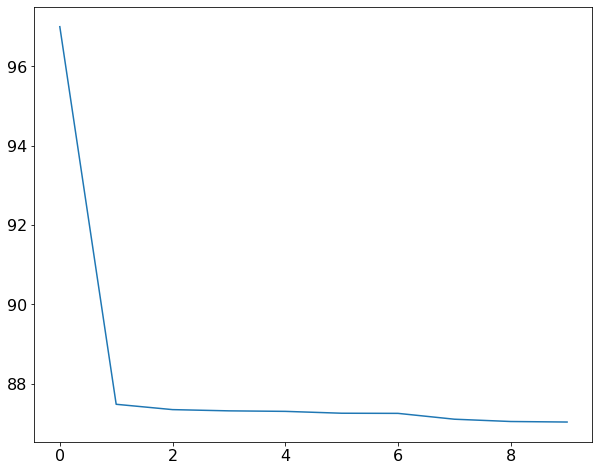

In [30]:
plt.plot(cpu_loss_stats)

## Latent Interpolation and Visualization


### Generated Image Visualization

**Implement** the following cell to generate 36 random samples from your previously trained VAE model and visualize the outputs. 

In [42]:
# ==== BEGIN SOLUTION CODE ====

model()
    
# ==== END SOLUTION CODE ====

TypeError: ignored

### Latent Interpolation

**Implement** the following cell to perform interpolation in latent space. Generate random latent vectors $z_0$ and $z_1$, and linearly interpolate between them; run each interpolated vector through the trained decoder to produce an image.

$$
z_{\mathrm{interpolate}} = r_1*z_1 + (1-r_2)*z_2
$$

Take 10 uniformly spaced samples for $r_1$ and $r_2$ in the range [0,1]. 

Each row of the figure should interpolates between two random vectors. For the most part the model should exhibit smooth transitions along each row, demonstrating that the model has learned something nontrivial about the underlying spatial structure of the digits it is modeling.

You should use the helper plotting function. You should have a 10x10 grid of images. 

In [ ]:
# ==== BEGIN SOLUTION CODE ====

## I guess we should use the mu and logvar from the above cell (ie the output of our trained model) and reparameterize to get z_1 and z_2 ? 

# ==== END SOLUTION CODE ====

# (Part 2) Generative Autoencoder - 60 pts




## Discriminator

We will use a discriminator inspired by the TensorFlow MNIST classification tutorial, which is able to get above 99% accuracy on the MNIST dataset fairly quickly. 
* Reshape into image tensor (Use `nn.Unflatten`!)
* Conv2D: 32 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

In [49]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    # ==== BEGIN SOLUTION CODE ====
    #self.discrimiator = nn.Sequential(
    self.unflatten = nn.Unflatten(dim = 1, unflattened_size=(1,28,28))
    self.cov1 =     nn.Conv2d(1,32,5)
    self.leakyReLU =     nn.LeakyReLU(.01)
    self.maxPool1 = nn.MaxPool2d(2, stride= 2 )
    self.cov2 =     nn.Conv2d(32,64,5, stride = 2)
    self.flatten =     nn.Flatten()
    self.fc1  =  nn.Linear(256, 4*4*16)
    #nn.LeakyReLU(.01)
    self.fc2 =     nn.Linear(4*4*16,1)

    #)
    # ==== END SOLUTION CODE ====


  def forward(self, x):
    """
    Performs forward pass through a discriminator model by passing image through
    the neural network described above. The output is a single scalar. 

    Inputs:
    - x: Batch of input images of shape (N, 1, H, W)

    Returns:
    - logits: PyTorch tensor of shape (N,1)
    """
    logits = None
    # ==== BEGIN SOLUTION CODE ====
    x = self.unflatten(x)
    x = self.cov1(x)
    x = self.leakyReLU(x)
    x = self.maxPool1(x)
    x = self.cov2(x)
    x = self.leakyReLU(x)
    x = self.maxPool1(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.leakyReLU(x)
    logits = self.fc2(x)
    #print('x.shape',x.shape)
    # ==== END SOLUTION CODE ====
    return logits  

*Implement* a sanity check for the Discriminator. Input a random sample with shape `(32, 784)` to a discriminator and check if the output is `(32,1)`. 

In [51]:
# ==== BEGIN SOLUTION CODE ====
rtensor = torch.rand((32,784))
check_discriminator = Discriminator()
output = check_discriminator(rtensor)
output.shape
# ==== END SOLUTION CODE ====

torch.Size([32, 1])

## Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. 

* Fully connected with output size 1024
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128 
* `ReLU`
* BatchNorm
* Reshape into Image Tensor of shape 7 x 7 x 128
* ConvTranspose2D: 64 filters of 4x4, stride 2, 'same' padding (use `padding=1`)
* `ReLU`
* BatchNorm
* ConvTranspose2D: 1 filter of 4x4, stride 2, 'same' padding (use `padding=1`)
* `TanH`
* Should have a 28 x 28 x 1 image, reshape back into 784 vector

In [102]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super().__init__()
        # ==== BEGIN SOLUTION CODE ====
        self.fc1 = nn.Linear(noise_dim, 1024)## arg1 = 28*28
        self.ReLU = nn.ReLU()
        self.batchNorm1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 7*7*128)
        #ReLU 
        self.batchNorm2 = nn.BatchNorm1d(7*7*128)

        self.unflatten = nn.Unflatten(1,(128,7,7))## reshape? 

        self.covT1  = nn.ConvTranspose2d(128,64,4,stride=2,padding=1 )
        self.batchNorm3 = nn.BatchNorm2d(64)#batchNorm
        self.covT2  = nn.ConvTranspose2d(64,1,4,stride=2,padding=1 )
        self.tanh = nn.Tanh()
        self.flatten = nn.Flatten()
 
        # ==== END SOLUTION CODE ====


    def forward(self, random_noise):
        """
        Generates a batch of images from a random noise sample after passing 
        through the neural network. The output is a batch of images. 

        Inputs:
        - x: Batch of random noise of shape (N, noise_dim)

        Returns:
        - fake_image: PyTorch tensor of shape (N, 1, 28, 28)
        """
        fake_image = None
        
        # ==== BEGIN SOLUTION CODE ====
        x = self.fc1(random_noise) 
        x = self.ReLU(x) 
        x = self.batchNorm1(x) 

        x = self.fc2(x) 
        x = self.ReLU(x)
        x = self.batchNorm2(x)

        x = self.unflatten(x)
        #print('before covT1',x.shape)
        x = self.covT1(x)
        x = self.ReLU(x)
        x = self.batchNorm3(x)
        #print('before covT2', x.shape)
        x = self.covT2(x)
        x = self.tanh(x)
        #print('before flatten', x.shape)
        fake_image = self.flatten(x)


        # ==== END SOLUTION CODE ====
        return fake_image

*Implement* a sanity check for the Generator with random noise size `96`. Input a random sample with shape `(32, 96)` to a Generator and check if the output is `(32, 784)`. 

In [103]:
# ==== BEGIN SOLUTION CODE ====
rtensor = torch.rand((32, 96))
check_generator = Generator(96)
output = check_generator(rtensor)
output.shape
# ==== END SOLUTION CODE ====

torch.Size([32, 784])

## GAN Loss

### Discriminator Loss

The discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.


For the purpose of these equations, we assume that the output from the discriminator is a real number in the range $0 < D(x) < 1$ which results from squashing the raw score from the discriminator through a sigmoid function. However for a cleaner and more numerically stable implementation, we have not included the sigmoid in the discriminator architecture above -- instead we will implement the sigmoid as part of the loss function.

**HINTS**: You can use the function [`torch.nn.functional.binary_cross_entropy_with_logits`](https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy_with_logits.html#torch.nn.functional.binary_cross_entropy_with_logits) to compute these losses in a numerically stable manner.

Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss (with logits) is defined as:

$$ bce(s, y) = -y * \log(\sigma(s)) - (1 - y) * \log(1 - \sigma(s)) $$

where $\sigma(s)=1/(1+\exp(-s))$ is the sigmoid function.

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. Make sure you cast these labels to the correct data type and device using the `dtype` and `device` variables, for example:

`true_labels = torch.ones(size, dtype=dtype, device=device)`

**Implement** the `Discriminator_Loss` in the following cell.


In [ ]:
%debug

In [115]:
def Discriminator_Loss(logits_real,
                       logits_fake,
                       device='cuda',
                       dtype=torch.float):
    """
    Computes the discriminator loss described above.

    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    - device: String  giving device type (default: 'cuda')
    - dtype: PyTorch type (default: torch.float)

    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
    loss = None
    # ==== BEGIN SOLUTION CODE ====
    ## logits_real is just 0 or 1 which is whether the image is fake or now 
    ## logits_fake is a probability 
    fake_labels = torch.ones(logits_fake.size, dtype = dtype, device = device)
    fake_loss = nn.functional.binary_cross_entropy_with_logits(logits_fake,fake_labels)## the reduction is already the mean

    real_labels = torch.zeros(logits_real.shape, dtype = dtype, device = device)
    real_loss = nn.functional.binary_cross_entropy_with_logits(logits_real,real_labels)
    # ==== END SOLUTION CODE ====
    return (real_loss + fake_loss)/2

### Generator Loss

The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$

This can be accomplished by comparing the outputs of $D(G(z))$, the fake logits, to the real labels. This may seem a bit counter-intuitive, but remember, we wish to only use the first term in the bce loss with logits and igonre the $log(1-\sigma(s))$ term. 


Instead of computing the expectation of $\log D(G(z))$, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. 

Same as the discriminator loss, you can use the function [`torch.nn.functional.binary_cross_entropy_with_logits`](https://pytorch.org/docs/stable/nn.functional.html#binary-cross-entropy-with-logits) to compute these losses in a numerically stable manner.

Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss (with logits) is defined as:

$$ bce(s, y) = -y * \log(\sigma(s)) - (1 - y) * \log(1 - \sigma(s)) $$

where $\sigma(s)=1/(1+\exp(-s))$ is the sigmoid function. Note in this case, you only have fake (zero) labels. 

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. Make sure you cast these labels to the correct data type and device using the `dtype` and `device` variables, for example:

`true_labels = torch.ones(size, dtype=dtype, device=device)`

**Implement** the `Generator_Loss` in the following cell. 

In [117]:
def Generator_Loss(logits_fake,
                   device='cuda',
                   dtype=torch.float):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    - device: String  giving device type (default: 'cuda')
    - dtype: PyTorch type (default: torch.float)

    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    loss = None
    # ==== BEGIN SOLUTION CODE ====
    real_labels = torch.ones(logits_fake.shape, dtype = dtype, device = device )
    loss = nn.functional.binary_cross_entropy_with_logits(logits_fake, real_labels)
    
    # ==== END SOLUTION CODE ====
    return loss

## Weight initializer

The GAN training is quite finicky, and seem to respond better to Xavier uniform initialization. 

**Run** the following cell to get define the `initialize_weights` function.

In [ ]:
def initialize_weights(m):
    """Initializes the weights of a torch.nn model using xavier initialization"""
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_uniform_(m.weight.data)

## GAN Training

We have defined the `Generator`, `Discriminator`, `Generator_Loss`, and `Discriminator_Loss`. We are now ready to actually train our GAN! 

Unlike the VAE, in which the encoder and decoder are updated jointly, the GAN training alternates between updating generator and discriminator. Thus, we actually have two distinct models, with two different optimizers. 

The GAN training algorithm is as follows: 

1. Instantiate a `Generator` and `Discriminator`. Use the `apply` method of the generator and discriminator to use the `initialize_weights` function and intialize the weights with a Xavier Uniform distribution scheme.
    - Suggested: latent dim = 96 or 74
2. Define optimizers for the generator and discriminator
    - Suggested: ADAM with lr=.001, beta1=0.5, beta2=0.999 
3. For each batch of data:
    - Zero the gradients in the discriminator
    - Get the logits of the real data from the discriminator
    - Generate random uniform noise of shape `(batch_size, latent_dim)`
    - Generate fake data using the random noise and the generator
    - Get the logits of the fake data from the discriminator
    - Calculate the discriminator loss, propagate the gradients, update using the discriminator optimizer. Use the previously defined `Discriminator_Loss` to calculate the discriminator loss.
    - Zero the gradients in the generator optimizer
    - Generate random uniform noise of shape `(batch_size, latent_dim)`
    - Generate fake data using the random noise and the generator
    - Get the logits of the fake data from the discriminator
    - Calculate the generator loss, propagate the gradients, update using the generator optimizer. Use the previously defined `Generator_Loss` to calculate the generator loss.

4. Repeat 3 for `num_epochs` times
    - Suggester: 10

The random noise input to the generator should be in the range (-1, 1). 

*Hint: Modify the PyTorch function `torch.Rand`  to be in the correct range for random sampling.* 

**Implement** the training loop in the following cell. 

*Following the suggested hyper-parameters, training takes approximately 2 minutes on a GPU.* 

In [ ]:
# Define num_epochs and device in the next section. 

# ==== BEGIN SOLUTION CODE ====



# ==== END SOLUTION CODE ====

for epoch in range(num_epochs):
    for x, _ in loader_train:
        # Drop the last batch with irregular size to simplify the code
        if len(x) != batch_size:
          continue
        
        # Do not delete: numerical trick to increase distance between
        # digit pixels and empty pixels
        real_data = x.view(-1, 784).to(device)
        real_data = 2*(real_data - 0.5)
        # Do no delete

        # ==== BEGIN SOLUTION CODE ====
      

        # ==== END SOLUTION CODE ====

## Latent Interpolation and Visualization


### Generated Image Visualization

**Implement** the following cell to generate 100 random samples from your previously trained Generator model and visualize the outputs. 

In [ ]:
# ==== BEGIN SOLUTION CODE ====

# ==== END SOLUTION CODE ====

### Latent Interpolation

**Implement** the following cell to perform interpolation in latent space. Generate random latent vectors $z_0$ and $z_1$, and linearly interpolate between them; run each interpolated vector through the trained generator to produce an image.

$$
z_{interpolate} = r_1*z_1 + (1-r_2)*z_2
$$

Take 10 uniformly spaced samples for $r_1$ and $r_2$ in the range [0,1]. 

Each row of the figure should interpolates between two random vectors. For the most part the model should exhibit smooth transitions along each row, demonstrating that the model has learned something nontrivial about the underlying spatial structure of the digits it is modeling.

You should use the helper plotting function. You should have a 10x10 grid of images. 

In [ ]:
# ==== BEGIN SOLUTION CODE ====

# ==== END SOLUTION CODE ====